# Musical Chord Classification
### Author(s): Khaled Alrashidi, Khushboo Khatri
### Credits: [Ahmet Çelik](https://www.kaggle.com/ahmetcelik158)

---

In [180]:
![Piano Keyboard](/Users/khaledalrashidi/Desktop/ML Projects/Musical-Chord-Classification/piano-keyboard-notes.png)

zsh:1: bad pattern: [Piano


In [181]:
# Importing necessary libraries
from IPython.display import Image, display
import os
import IPython
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## 1. Understanding Math Behind Music

### 1.1. Notes and Chords

<!-- ![Notes.png](attachment:piano-keyboard-notes.jpg) -->

Notes are the fundamental building blocks of music. In Western music, there are seven natural notes represented by the letters A, B, C, D, E, F, and G. These notes correspond to the white keys on a piano. Typically, the interval between two natural notes is a whole step, except for two cases: there is no note between B & C and E & F. The smallest interval in music is a half step, which is represented by the black keys on a piano. For instance, the note between A and B can be referred to as A Sharp (A#) or B Flat (Bb). Altogether, when including these intermediate notes, there are 12 notes in total:

A A# B C C# D D# E F F# G G#

One of the key characteristics of a note is its frequency. In Western music, note frequencies can be calculated based on certain rules:

    The reference note is A with a frequency of 440 Hz.
    Doubling the frequency of a note produces the same note an octave higher.
    Intervals between consecutive notes are equal on a logarithmic scale.

Let's perform some calculations. Using the first two rules, if 440 Hz corresponds to "A", then 880 Hz also corresponds to "A" an octave higher. Conversely, 220 Hz is "A" an octave lower. Note that 660 Hz is not "A". According to the third rule, since there are 12 notes, we multiply by 2^(1/12) to find the frequency of the next note. Starting from "A" (440 Hz), (440 * 2^(1/12)) gives us "A#", (440 * 2^(1/12) * 2^(1/12)) gives us "B", and so on. After 12 steps, the resulting frequency is (440 * 2^(12/12)) = 880 Hz, which is again "A". Fascinating, isn't it? Now that we've covered the theory, let's use Python for the calculations.

In [182]:
warnings.filterwarnings('ignore')
# Define the starting frequency for "A" note
# Human hearing range is typically 20 Hz to 20 kHz
# We start with 55 Hz which is an "A" (calculated by dividing 440 Hz by 2 three times)
curr_freq = 55
freq_list = []

# Calculate the frequencies for 8 octaves, each with 12 notes
for i in range(96): 
    freq_list.append(curr_freq)
    curr_freq *= np.power(2, 1/12)  # Multiply by 2^(1/12) to get the next note frequency

# Reshape the frequency list into an 8x12 array and create a DataFrame for better visualization
freq_array = np.reshape(np.round(freq_list, 1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)

# Display the DataFrame
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
0,55.0,58.3,61.7,65.4,69.3,73.4,77.8,82.4,87.3,92.5,98.0,103.8
1,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7
2,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3
3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6
4,880.0,932.3,987.8,1046.5,1108.7,1174.7,1244.5,1318.5,1396.9,1480.0,1568.0,1661.2
5,1760.0,1864.7,1975.5,2093.0,2217.5,2349.3,2489.0,2637.0,2793.8,2960.0,3136.0,3322.4
6,3520.0,3729.3,3951.1,4186.0,4434.9,4698.6,4978.0,5274.0,5587.7,5919.9,6271.9,6644.9
7,7040.0,7458.6,7902.1,8372.0,8869.8,9397.3,9956.1,10548.1,11175.3,11839.8,12543.9,13289.8


Notes can be played either in sequence to create a melody or simultaneously to form a chord. In music, a chord consists of three or more different notes sounded together. The most common types of chords are Major and Minor chords, each composed of three notes. To form a Major chord, start with a root note, move up 2 whole steps to find the second note, and then move up 1.5 steps to find the third note. For example, in a C Major chord, the root note is "C", the second note is "E", and the third note is "G".

Forming a Minor chord follows a similar process but with different intervals. Starting from the root note, move up 1.5 steps to find the second note and then move up 2 whole steps to find the third note. For instance, in a C Minor chord, the notes are "C", "Eb", and "G". (Note: Eb and D# have the same frequencies.)

The dataset we are using contains recordings of various Major and Minor chords in WAV format. Since the project aims to distinguish between Major and Minor chords, the intervals between the notes are crucial. We will focus on these intervals rather than the individual notes of each chord. Now, let's listen to some chord examples. Using the IPython package, we can display and play audio directly within the notebook.

In [183]:
path_1 = "./Audio_Files/Major/Major_0.wav"
path_2 = "./Audio_Files/Minor/Minor_169.wav"
path_3 = "./Audio_Files/Major/Major_111.wav"
IPython.display.Audio(path_1, rate = 44100)

In [184]:
IPython.display.Audio(path_2, rate = 44100)

In [185]:
IPython.display.Audio(path_3, rate = 44100)

In the previous section, we learned that notes have specific frequencies that define them. For instance, a sound wave with a frequency of 220 Hz corresponds to an "A" note. Now comes the fascinating part. In nature, musical sound waves never vibrate at a single frequency. When an instrument plays a note, harmonics of that note occur at integer multiples of the base frequency. Playing an "A" note at 220 Hz also generates waves at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. We know that 220 Hz, 440 Hz, and 880 Hz are all "A" notes. However, 660 Hz is an "E" note, and 1000 Hz falls between "C" and "C#". This interplay of frequencies creates harmony and is why certain combinations of notes sound beautiful together. Each note inherently contains other notes within its harmonics.

To better illustrate the concept of harmonics, let's create a computer-generated note. A sine wave, represented by Asin⁡(2πft)Asin(2πft), where AA is the amplitude, ff is the frequency, and tt is time, can model a wave at a single frequency. To simulate a sound wave with harmonics, we'll first create a sine wave with the fundamental frequency and then add its harmonics using a loop. Another crucial variable is the sampling rate, which determines how many samples we record per second. In practice, a sampling rate of 44,100 Hz is common.

The generated signal will be in the time domain. After creating the signal, we will apply a Fourier Transform to convert it into the frequency domain using the SciPy FFT package. The FFT method provides both positive and negative frequency components, but we only need the positive terms. For more detailed information about FFT, refer to the SciPy FFT documentation.

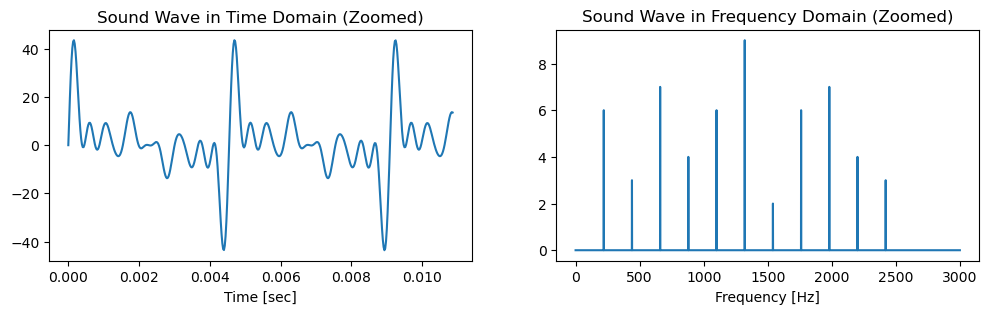

In [186]:
freq = 220 # note frequency
fs = 44100 # sampling rate
duration = 1 # duration of a signal [seconds]
time = np.linspace(0, duration, fs*duration, endpoint=False) # array for time stamps

# Creating signal in time domain
np.random.seed(42)
signal = np.zeros(len(time))
for i in range(1,12):
    amp = np.random.randint(0,10) # using random numbers for amplitudes
    current_freq = i*freq # current harmonic
    signal += amp*np.sin(2 * np.pi * current_freq * time)

# Fourier Transform
N = len(signal)
y_freq = fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Displaying audio
IPython.display.display(IPython.display.Audio(data=signal, rate=44100))

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(time[:480], signal[:480])
axes[0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[0].set(xlabel='Time [sec]')
axes[1].plot(y_freq[:3000], signal_f_onesided[:3000])
axes[1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1].set(xlabel='Frequency [Hz]')
plt.show()

Upon listening to the audio I generated, it's evident that it's a computer-generated sound rather than a natural one. Nonetheless, it represents an "A" note, and the frequency plot provides us with valuable insights. We can observe the specific frequencies present in our signal, understand the harmonic structure of a musical wave, and identify the frequencies corresponding to each note.

Now, it's time to analyze our real recordings. The WAV files contain Major and Minor chords, each with at least three notes. I expect the Fourier transform to produce a more complex frequency plot, resembling an overlap of three individual plots. The intervals between harmonics will not be equal, which is ideal for my purposes since I plan to build a classification model based on the relationships between these harmonics.

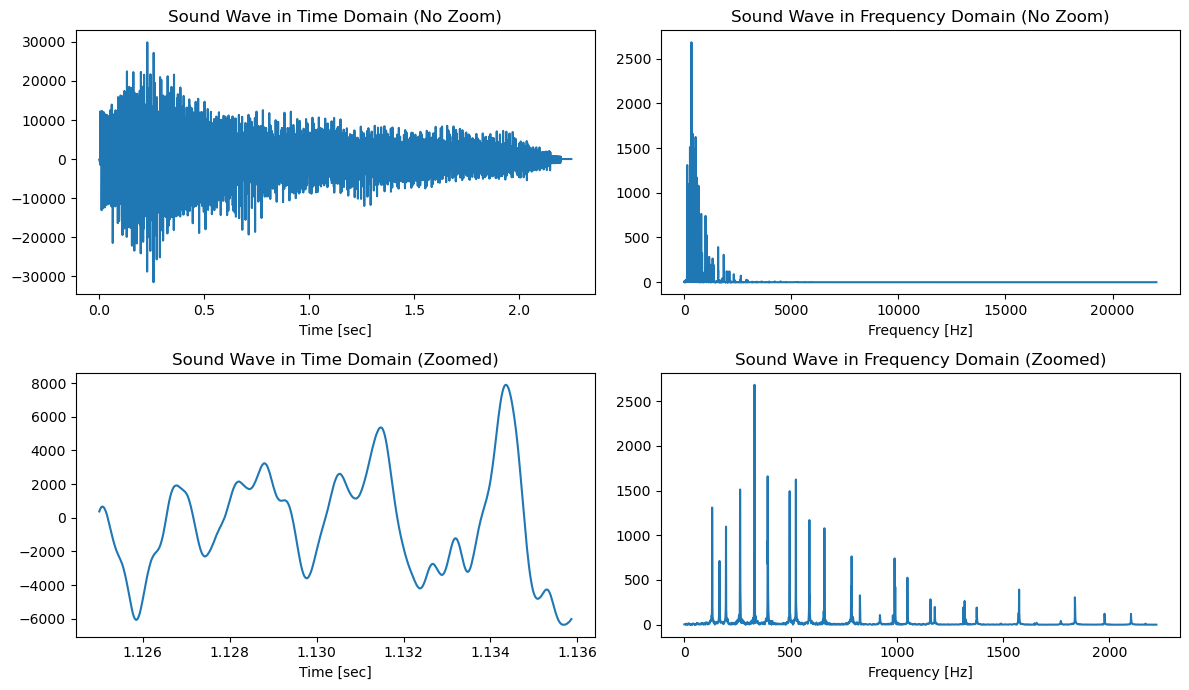

In [187]:
path = "./Audio_Files/Major/Major_0.wav"
fs, signal = wavfile.read(path)
N = len(signal)
time = np.linspace(0., N/fs, N)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (No Zoom)")
axes[0,0].set(xlabel='Time [sec]')
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel='Frequency [Hz]')
axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel='Time [sec]')
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel='Frequency [Hz]')
fig.tight_layout()
plt.show()

### 1.3. Spectrogram

In the previous section, we examined the time and frequency plots of a sound wave. Now, let's also visualize the spectrogram of the signal. A spectrogram is a powerful tool for displaying how the signal's frequency content evolves over time. It is created by splitting the signal into small time segments and applying the Fourier transform to each segment. The result is a 2D matrix that can be plotted. Fortunately, SciPy provides a convenient method for generating spectrograms, so we don't have to perform the calculations from scratch. You can find the documentation for the spectrogram method here.

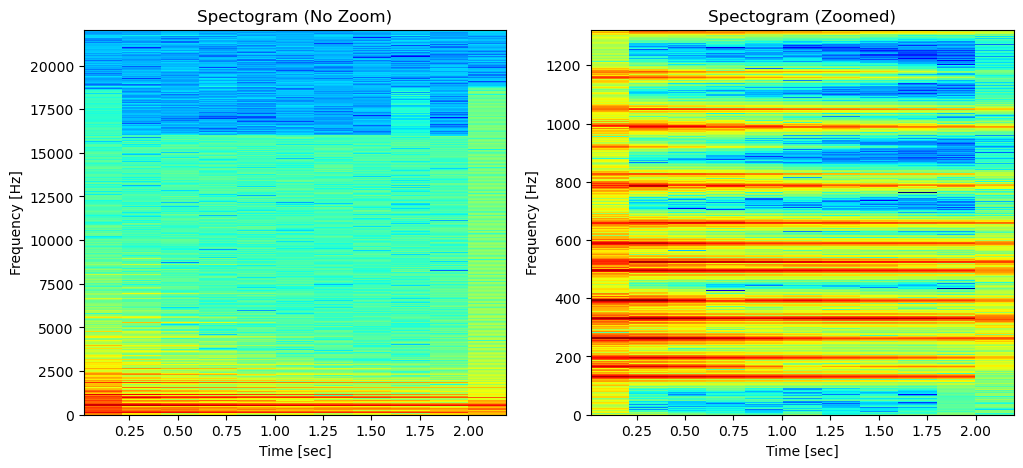

In [188]:
# Applying spectrogram
f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap="jet")
axes[0].set_title("Spectogram (No Zoom)")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap="jet")
axes[1].set_title("Spectogram (Zoomed)")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

### 1.4. Detection of Harmonic Frequencies

To summarize our progress so far, we have successfully read a WAV file and stored it in an array representing the time domain. By applying the Fourier transform, we converted this array into the frequency domain. Additionally, we generated a spectrogram to obtain a 2D matrix that includes both time and frequency information. However, for this project, the time-domain array is not suitable for use. Similarly, the spectrogram matrix will not be used since our recordings contain only one chord, meaning the frequency information remains constant over time. If we had recordings where chords changed every second, the spectrogram would show harmonics shifting accordingly.

For this project, we will proceed with the frequency array. The frequency plot reveals peak values that represent harmonics. I believe that identifying the frequencies at which these peaks occur will provide valuable data for building a model. To achieve this, I will use the find_peaks method from SciPy, which returns the indices of the peaks. By plugging these indices into the frequency stamp array, we can determine the harmonic frequencies.

Update: In some files, I have observed peaks at very low frequencies, such as 2 Hz. Any peak below 50 Hz will be ignored as it is most likely noise.


Harmonics: [ 131.  165.  196.  262.  330.  392.  496.  525.  588.  659.  787.  826.
  989. 1050. 1158. 1179. 1312. 1319. 1376. 1576. 1838.]


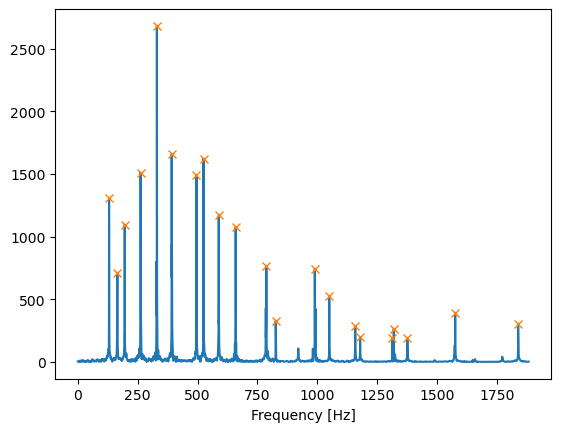

In [189]:
# h: height threshold. I defined as %5 of max value
h = signal_f_onesided.max()*5/100
peaks, _ = find_peaks(signal_f_onesided, distance=10, height = h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz
peaks = peaks[peaks>freq_50_index] # filtering peaks less than 50 Hz
harmonics = y_freq[peaks]
print("Harmonics: {}".format(np.round(harmonics)))

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], "x")
plt.xlabel('Frequency [Hz]')
plt.show()

In [190]:
# The method below will read sound file, apply Fourier, find peak frequencies and return
# Input: path of the sound file
# Output: Frequency peaks
# print_peaks = true to plot peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

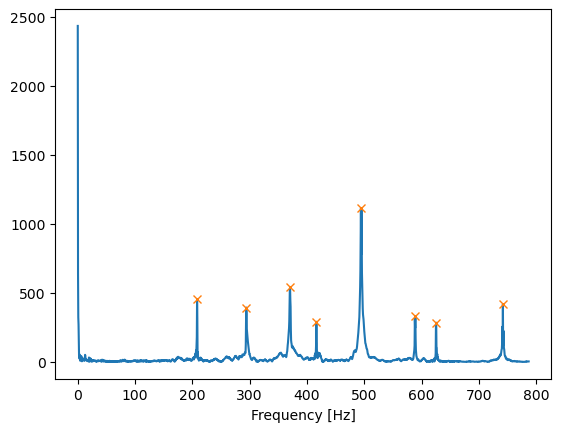

Harmonics: [208. 294. 370. 416. 494. 589. 625. 742.]


In [191]:
# Another example to check if method is working correctly
path = "./Audio_Files/Minor/Minor_169.wav"

harmonics_2 = find_harmonics(path, print_peaks=True)
print("Harmonics: {}".format(np.round(harmonics_2)))

### 2. Importing Dataset

In this section, I will create a DataFrame to analyze all the sound data collectively. There are over 800 WAV files in total. First, I will loop through each file to find the harmonics. For each file, I will save the chord type, file name, and all identified harmonics. Additionally, I will record the minimum and maximum harmonics as well as the total number of harmonics to facilitate easier analysis. Once the loop is complete, I will convert this information into a DataFrame.

In [192]:
# path = "/Users/khaledalrashidi/Desktop/ML Projects/Musical-Chord-Classification/Audio_Files"
path = "/Users/khaledalrashidi/Desktop/Musical-Chord-Classification/Audio_Files"

data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns


# Walk through the directory and process each file
for dirname, _, filenames in os.walk(path):
    print(f"Checking directory: {dirname}")
    for filename in filenames:
        if filename.endswith('.wav'):  # Ensure the file is a wav audio file
            foldername = os.path.basename(dirname)
            full_path = os.path.join(dirname, filename)
            # print(f"Processing file: {full_path}")
            freq_peaks = find_harmonics(full_path)
            
            max_harm_length = max(max_harm_length, len(freq_peaks))
            
            cur_data = [foldername, filename]
            if len(freq_peaks) > 0:
                cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
            else:
                cur_data.extend([np.nan, np.nan, 0])
            cur_data.extend(freq_peaks)
            
            data.append(cur_data)

Checking directory: /Users/khaledalrashidi/Desktop/Musical-Chord-Classification/Audio_Files
Checking directory: /Users/khaledalrashidi/Desktop/Musical-Chord-Classification/Audio_Files/Major
Checking directory: /Users/khaledalrashidi/Desktop/Musical-Chord-Classification/Audio_Files/Minor


In [193]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_500.wav,116.82,2102.27,27,116.82,165.45,221.36,233.64,262.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_266.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_272.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_299.wav,147.11,741.78,12,147.11,208.44,233.33,262.22,293.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_474.wav,116.89,1960.00,25,116.89,175.11,228.44,234.22,294.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. Data Exploration

* Finally, we have a nice DataFrame to make some exploration. The first column, Chord Type, is the value that we will predict. It is a categorical column consisting of 2 categories: Major and Minor. By printing value counts of Chord Type, it seems that most of the chords are Major. We have 502 Major chords and 357 Minor chords. 

* The second column is the file name that the row is created from. We will not need this column for model building, I just keep it in case I want to analyze a specific row deeper.

In [194]:
df["Chord Type"].value_counts()

Chord Type
Major    502
Minor    357
Name: count, dtype: int64

### 3.1. Min and Max Harmonics

In this part, I have plotted the distributions of the minimum and maximum harmonics. By setting the hue to represent the chord type, we can observe if and how chord type affects these distributions. As expected, the distribution of minimum harmonics for Major and Minor chords is extremely similar. This is because the minimum harmonic determines the root note of the chord. For instance, with a frequency of 110 Hz, the chord could be either "A Major" or "A Minor". We cannot distinguish the chord type solely based on the root note. The difference between Major and Minor chords lies in the intervals between the harmonics.

When examining the distribution of maximum harmonics, we again see similar patterns for Major and Minor chords. Although there is a slight difference, it is not significant enough to consider for this analysis. Consequently, I have decided not to use the "Min Harmonic" and "Max Harmonic" columns in my model building.

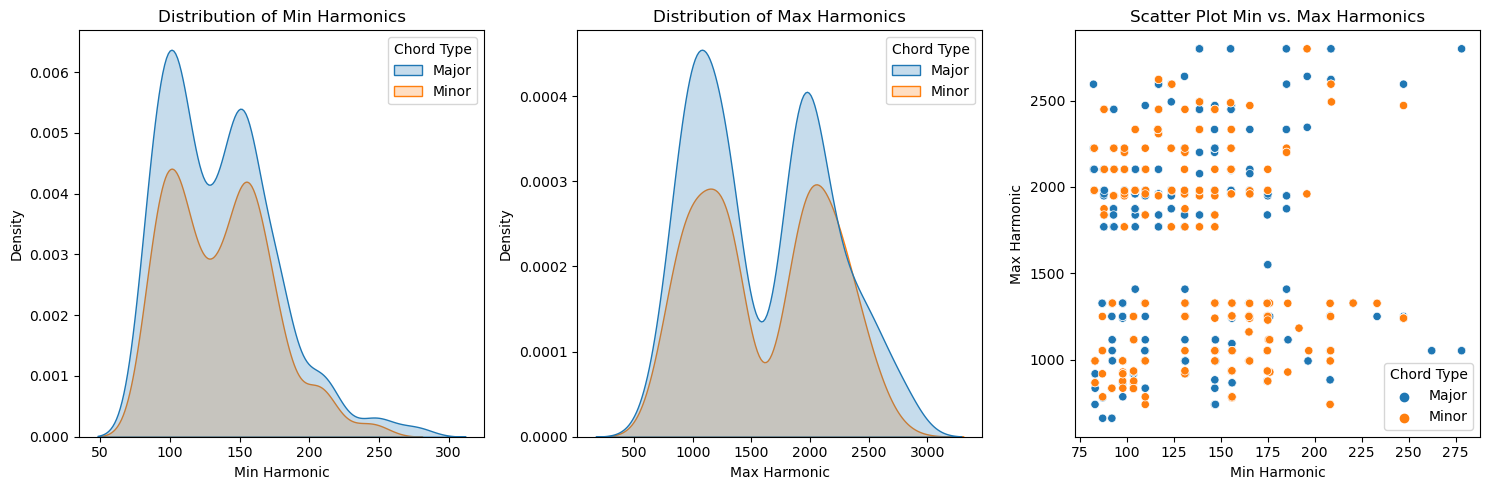

In [195]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", shade=True)
sns.scatterplot(ax=axes[2], data=df, x="Min Harmonic", y="Max Harmonic",hue="Chord Type")
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
axes[2].set_title("Scatter Plot Min vs. Max Harmonics")
fig.tight_layout()
plt.show()

### 3.2. Number of Harmonics

In the "# of Harmonics" column, I have information about the number of harmonic values that are not null in each row. For example, if the "# of Harmonics" value is 12, that row will contain values from "Harmonic 1" to "Harmonic 12", with subsequent columns (e.g., "Harmonic 13" onwards) containing NaN values. While the "# of Harmonics" column will not be directly used in my classification model, it will facilitate the analysis of other columns.

Using the describe method on the "# of Harmonics" column, we observe the following:

* The minimum number of harmonics is 8, indicating that every row has at least 8 harmonic values.
* The maximum number of harmonics is 38, making "Harmonic 38" the last column.
* Starting from the "Harmonic 9" column, there will be NaN values.
* As harmonics are ordered, the number of missing values increases with each subsequent column.
* The mean number of harmonics is 20.

Given the number of missing values, it is clear that I will need to drop many columns. Harmonics beyond the 20th are mostly absent. The first 8 harmonics are crucial, but the importance of the harmonics in between remains uncertain. Further exploration is required to make an informed decision about these intermediate harmonics.

In [196]:
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [197]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
# miss_values[miss_values>0]

Number of Missing values:


### 3.3. Feature Engineering on Harmonics

Let's begin exploring the harmonics. Since "Harmonic 1" is the same as the "Min Harmonic" column due to the ordered nature of harmonics, we will start with "Harmonic 2". When I plotted the distribution of "Harmonic 2" with the hue set to Chord Type, I couldn't identify a direct relationship between "Harmonic 2" and the chord type.

However, I have an idea. We know that the difference between Major and Minor chords arises from the intervals between the harmonics, and that the frequency of notes increases on a logarithmic scale. By dividing "Harmonic 2" by "Harmonic 1", we can calculate the first interval.

In [198]:
df_original = df.copy() # Keeping original of df, I may need later

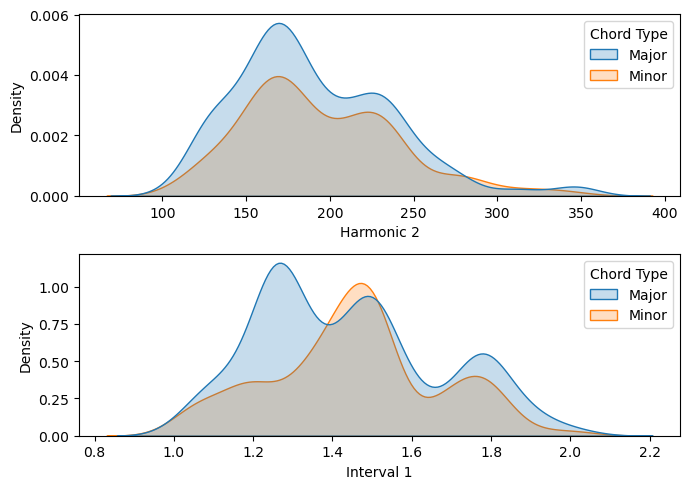

In [199]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

I'm pleased with the distribution of Interval 1. Finally, we have data that varies with Chord Type. I will continue calculating intervals using a loop. Although there are 38 harmonics, we know that higher harmonics have a significant amount of missing values. Therefore, I will loop through the first 20 intervals. For each interval, I will calculate the ratio of the current harmonic to the previous one.

In [200]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_500.wav,116.82,2102.27,27,116.82,165.45,221.36,233.64,262.27,...,1.264284,1.058943,1.121036,1.041574,1.007756,1.070417,1.121779,1.057726,1.054566,1.046403
1,Major,Major_266.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,1.187711,1.122396,1.040740,1.014974,1.054444,1.010227,1.185295,1.124893,1.040732,1.067923
2,Major,Major_272.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,1.187711,1.122396,1.040740,1.075415,1.005360,1.185295,1.124893,1.040732,1.067923,1.008263
3,Major,Major_299.wav,147.11,741.78,12,147.11,208.44,233.33,262.22,293.78,...,1.186222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_474.wav,116.89,1960.00,25,116.89,175.11,228.44,234.22,294.67,...,1.192320,1.115118,1.046506,1.067207,1.010662,1.060309,1.120849,1.115858,1.005303,1.194876


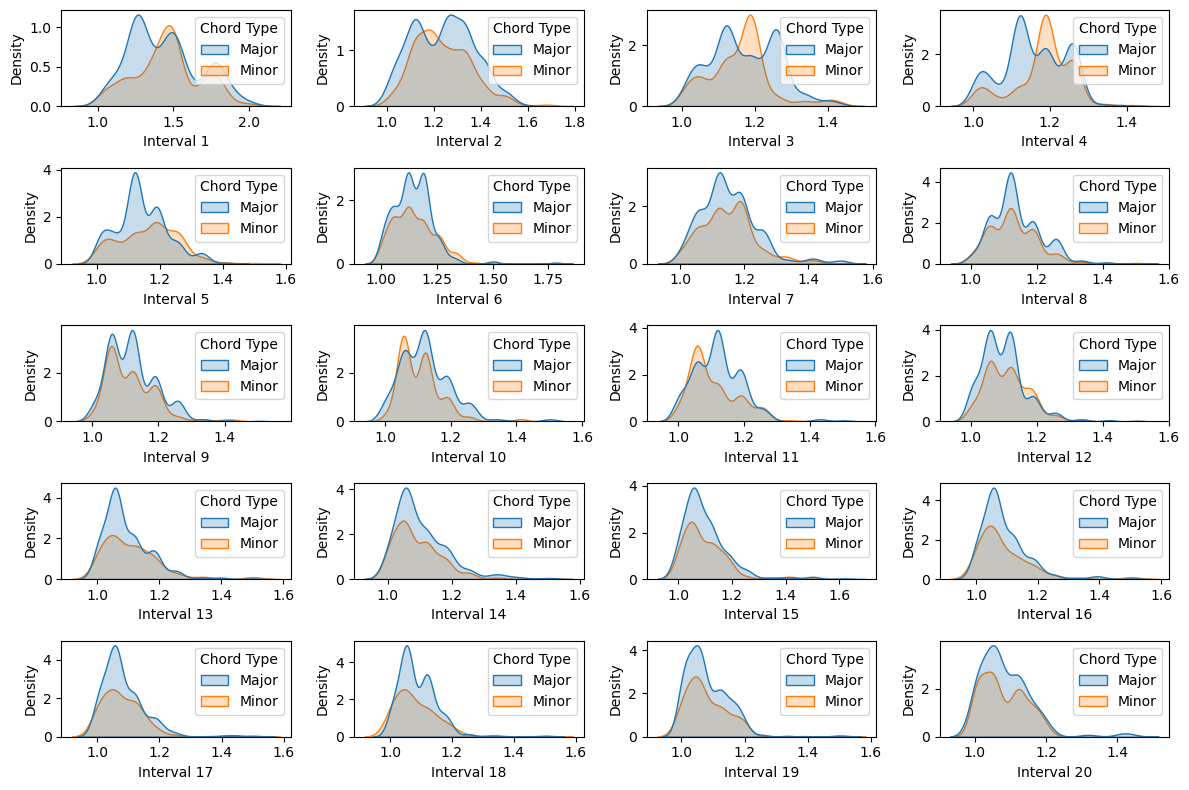

In [201]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

Upon examining the comprehensive plot of intervals:

* The first four intervals look interesting and will be included in my model.
* After interval 13, the variable loses its significance entirely.
* Starting from interval 8, there are missing values, so I will likely drop these intervals.
* Intervals 5, 6, and 7 have no missing values; I will decide on their inclusion later.

So far, we have analyzed the intervals between consecutive harmonics. Now, let's consider the total interval up to a specific harmonic, meaning the interval between the specific harmonic and the first harmonic. I will plot these intervals using a loop.

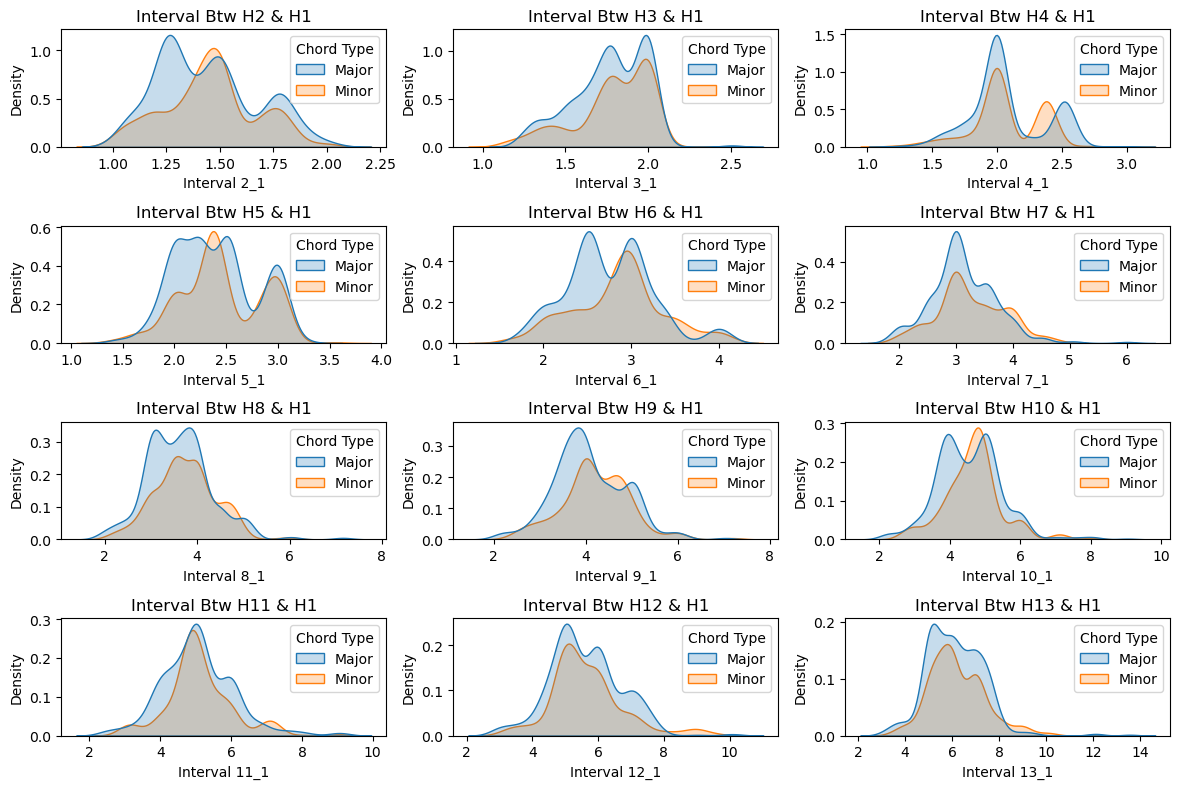

In [202]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

The interval between H2 & H1 looks promising, but it provides the same information as "Interval 1" that we already calculated. The interval between H3 & H1 didn't seem relevant. However, the next three plots are perfect and will be included in my model. Therefore, this concludes our interval analysis. I believe the most meaningful intervals for the model are:

* Interval 1
* Interval 2
* Interval 3
* Interval 4
* Interval 4_1
* Interval 5_1
* Interval 6_1

### 4. Model Building

In [203]:
# importing packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### 4.1. Preprocessing Data

There is just one step left before training the classification model. Since the Chord Type column is categorical and consists of strings, I will replace "Major" with 1 and "Minor" with 0. Finally, I will select the columns to be used in training and split the data into training and validation sets, using a test size of 40%.

In [204]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4"]
columns.extend(["Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.30, random_state=0, stratify=df["Chord Type"])

train_X.head()

,Interval 1,Interval 2,Interval 3,Interval 4,Interval 4_1,Interval 5_1,Interval 6_1
556,1.506012,1.330672,1.191909,1.259324,2.388595,3.008016,3.376480
558,1.502198,1.304709,1.024930,1.185884,2.008791,2.382194,2.844322
336,1.688325,1.187333,1.125262,1.189703,2.255704,2.683618,3.004605
117,1.484498,1.347188,1.187244,1.252315,2.374367,2.973455,3.017528
807,1.416281,1.184104,1.192588,1.190635,2.000000,2.381270,2.828711


### 4.2. Model Exploration

In order to select a classification model, I will try 6 different models in this section and compare their cross validation score.

In [205]:
lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

score_lr = cross_val_score(lr, train_X, train_y, cv=10).mean()
score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_svc = cross_val_score(svc, train_X, train_y, cv=10).mean()
score_gnb = cross_val_score(gnb, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()

In [206]:
print("Cross Val Score for Logistic Regression: {:.2f}".format(score_lr))
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for SVC: {:.2f}".format(score_svc))
print("Cross Val Score for Gaussian NB: {:.2f}".format(score_gnb))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))

Cross Val Score for Logistic Regression: 0.61
Cross Val Score for KNeighbors Classifier: 0.84
Cross Val Score for SVC: 0.62
Cross Val Score for Gaussian NB: 0.60
Cross Val Score for Decision Tree Classifier: 0.89
Cross Val Score for Random Forest Classifier: 0.91


As we can see the top three models are KNN, decision tree, and random forest. So, we will perform a GirdSearch for each one, find the best parameters, and evaluate them on the test set.

### 4.3. GridSearch

#### 4.3.1 KNN Classifier

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
KNN Accuracy: 0.9302325581395349
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       107
           1       0.96      0.92      0.94       151

    accuracy                           0.93       258
   macro avg       0.93      0.93      0.93       258
weighted avg       0.93      0.93      0.93       258

KNN Confusion Matrix:
 [[101   6]
 [ 12 139]]


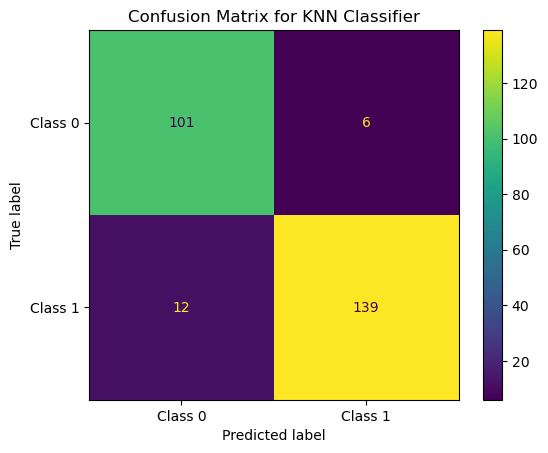

In [207]:
# Define parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV for KNN
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=10, scoring='accuracy')
grid_knn.fit(train_X, train_y)

# Best parameters and model evaluation
best_knn = grid_knn.best_estimator_
print("Best Parameters for KNN:", grid_knn.best_params_)

# Train and evaluate on the test set
knn_pred = best_knn.predict(val_X)
cm = confusion_matrix(val_y, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

print("KNN Accuracy:", accuracy_score(val_y, knn_pred))
print("KNN Classification Report:\n", classification_report(val_y, knn_pred))
print("KNN Confusion Matrix:\n", cm)

disp.plot()
plt.title('Confusion Matrix for KNN Classifier')
plt.show()


#### 4.3.2. Random Forest Classifier

Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest Accuracy: 0.9534883720930233
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       107
           1       0.96      0.96      0.96       151

    accuracy                           0.95       258
   macro avg       0.95      0.95      0.95       258
weighted avg       0.95      0.95      0.95       258

Random Forest Confusion Matrix:
 [[101   6]
 [  6 145]]


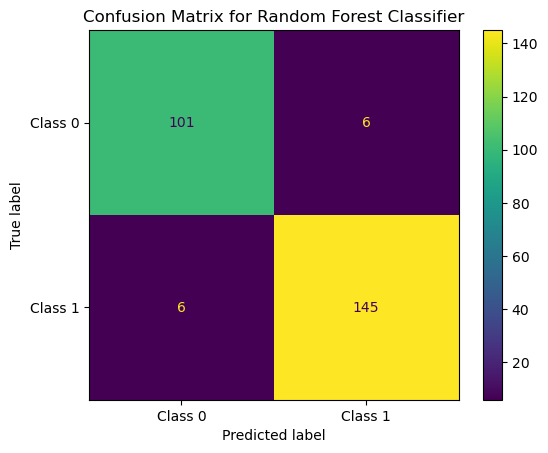

In [208]:
# Define parameter grid for Random Forest
param_grid_rfc = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

# Perform GridSearchCV for Random Forest
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=0), param_grid_rfc, cv=10, scoring='accuracy')
grid_rfc.fit(train_X, train_y)

# Best parameters and model evaluation
best_rfc = grid_rfc.best_estimator_
print("Best Parameters for Random Forest:", grid_rfc.best_params_)

# Train and evaluate on the test set
rfc_pred = best_rfc.predict(val_X)
cm = confusion_matrix(val_y, rfc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

print("Random Forest Accuracy:", accuracy_score(val_y, rfc_pred))
print("Random Forest Classification Report:\n", classification_report(val_y, rfc_pred))
print("Random Forest Confusion Matrix:\n", confusion_matrix(val_y, rfc_pred))

disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

#### 4.3.3. Decision Tree Classifier

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Decision Tree Accuracy: 0.8953488372093024
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87       107
           1       0.89      0.93      0.91       151

    accuracy                           0.90       258
   macro avg       0.90      0.89      0.89       258
weighted avg       0.90      0.90      0.89       258

Decision Tree Confusion Matrix:
 [[ 90  17]
 [ 10 141]]


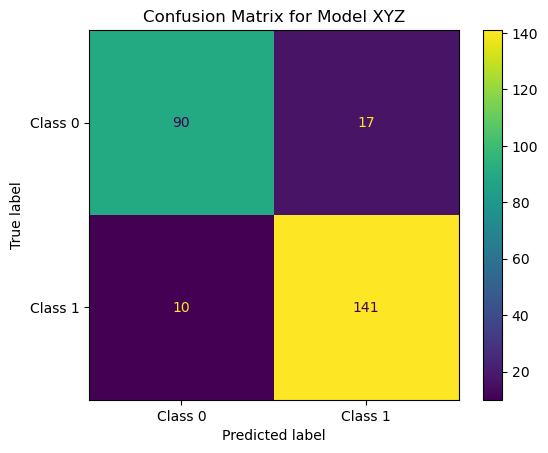

In [209]:
# Define parameter grid for Decision Tree
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [6, 8, 10, 12, 14, 16],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV for Decision Tree
grid_dtc = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid_dtc, cv=10, scoring='accuracy')
grid_dtc.fit(train_X, train_y)

# Best parameters and model evaluation
best_dtc = grid_dtc.best_estimator_
print("Best Parameters for Decision Tree:", grid_dtc.best_params_)

# Train and evaluate on the test set
dtc_pred = best_dtc.predict(val_X)
cm = confusion_matrix(val_y, dtc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

print("Decision Tree Accuracy:", accuracy_score(val_y, dtc_pred))
print("Decision Tree Classification Report:\n", classification_report(val_y, dtc_pred))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(val_y, dtc_pred))

disp.plot()
plt.title('Confusion Matrix for Model XYZ')
plt.show()

### 4.4. Model Selection

I evaluated six different models, and fine tuned the top three models, which are the Random Forest, the Decision Tree, and K-Neighbors Classifiers. The models performed better after doing some fine tuning. 

The Random Forest Classifier performed exceptionally well with a success rate of 95%. Following it, the K-Neighbors Classifier achieved a 93% success rate, and the Decision Tree Classifier obtained an 90% success rate.

Moving forward, I will continue with the Random Forest Classifier. First, I will train the model using the training dataset and then make predictions on the validation dataset to evaluate its accuracy.

### 4.5. Model Training and Evaluation 

In [210]:
# defining the RF classifier
classifier = RandomForestClassifier(criterion='gini', max_depth=10, max_features='sqrt', n_estimators=100)

classifier.fit(train_X, train_y) # training classifier
pred_y = classifier.predict(val_X) # making prediction on validation

#### 4.5.1. Confusion Matrix & Accuracy Rate 

Accuracy Score: 0.95


Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

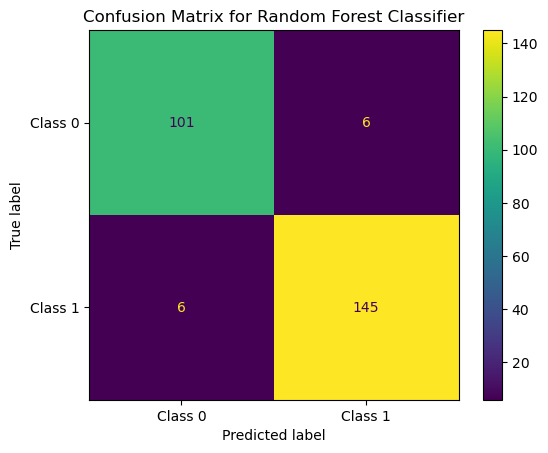

In [211]:
acc = accuracy_score(val_y, pred_y)
plt.show()
print("Accuracy Score: {:.2f}".format(acc))

cm = confusion_matrix(val_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot()
plt.title('Confusion Matrix for Random Forest Classifier')

#### 4.5.2. ROC

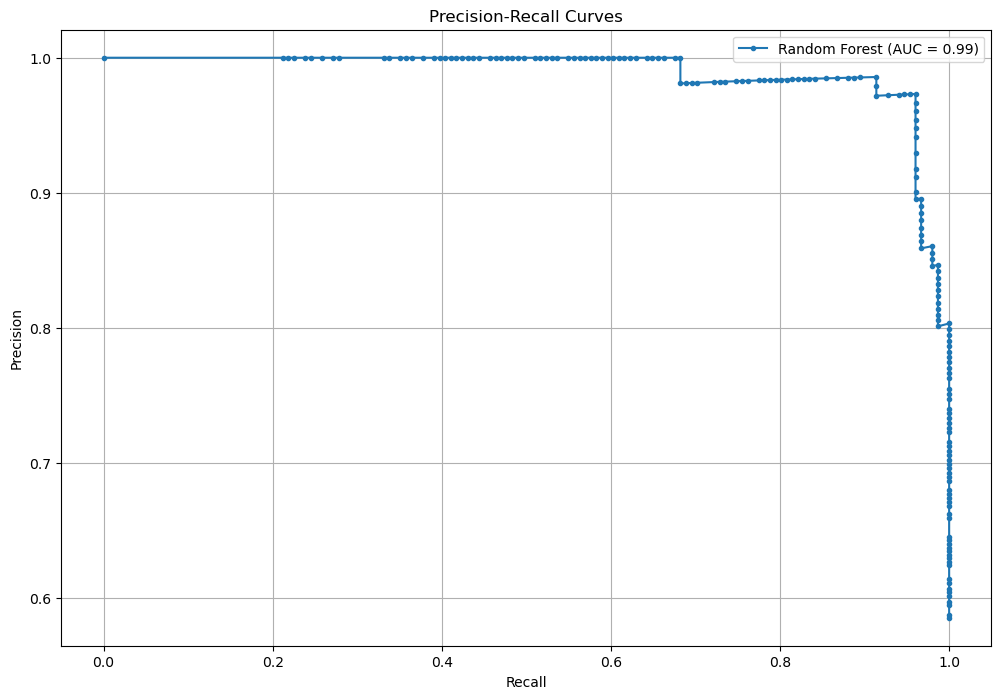

In [212]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUC = {pr_auc:.2f})')

plt.figure(figsize=(12, 8))

rfc_probs = classifier.predict_proba(val_X)[:, 1]  # Get the probabilities for the positive class
plot_precision_recall_curve(val_y, rfc_probs, 'Random Forest')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

---

### Deep learning model: Convolutional Neural Netowrk (CNN)
* We want to see how well a deep learning model like a Convolutional neural netowrk perofrm on classifying the musical chords.


### 5. CNN Model

In [227]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4",
           "Interval 4_1", "Interval 5_1", "Interval 6_1"]

# Splitting the data into train and validation sets
X = df[columns]
y = df["Chord Type"]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

# Standardizing the data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)

# Reshaping data to fit into CNN model (CNN expects 3D input)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

### 5.1. CNN Architecture 

In [267]:
# Building the CNN model
model = Sequential()
model.add(Conv1D(256, kernel_size=4, activation='relu', input_shape=(train_X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

### 5.2. CNN Model Training

In [268]:
# Training the model
history = model.fit(train_X, train_y, epochs=300, validation_data=(val_X, val_y), batch_size=64)

Epoch 1/300
10/10 [==============================] - 0s 11ms/step - loss: 0.6734 - accuracy: 0.5691 - val_loss: 0.6462 - val_accuracy: 0.5853
Epoch 2/300
10/10 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6073 - val_loss: 0.6311 - val_accuracy: 0.6202
Epoch 3/300
10/10 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6972 - val_loss: 0.6109 - val_accuracy: 0.6977
Epoch 4/300
10/10 [==============================] - 0s 4ms/step - loss: 0.5791 - accuracy: 0.7371 - val_loss: 0.5860 - val_accuracy: 0.7481
Epoch 5/300
10/10 [==============================] - 0s 4ms/step - loss: 0.5626 - accuracy: 0.7687 - val_loss: 0.5650 - val_accuracy: 0.7829
Epoch 6/300
10/10 [==============================] - 0s 4ms/step - loss: 0.5358 - accuracy: 0.7754 - val_loss: 0.5440 - val_accuracy: 0.7907
Epoch 7/300
10/10 [==============================] - 0s 10ms/step - loss: 0.5139 - accuracy: 0.7887 - val_loss: 0.5120 - val_accuracy: 0.8101
Epoch 8/300

### 5.3. CNN Model Evaluation

In [269]:
# Evaluating the model
val_loss, val_accuracy = model.evaluate(val_X, val_y)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predicting the validation set
val_y_pred = (model.predict(val_X) > 0.5).astype("int32")

9/9 [==============================] - 0s 606us/step - loss: 0.2064 - accuracy: 0.9457
Validation Loss: 0.20635226368904114
Validation Accuracy: 0.9457364082336426
9/9 [==============================] - 0s 604us/step


#### 5.3.1. Confusion Matrix

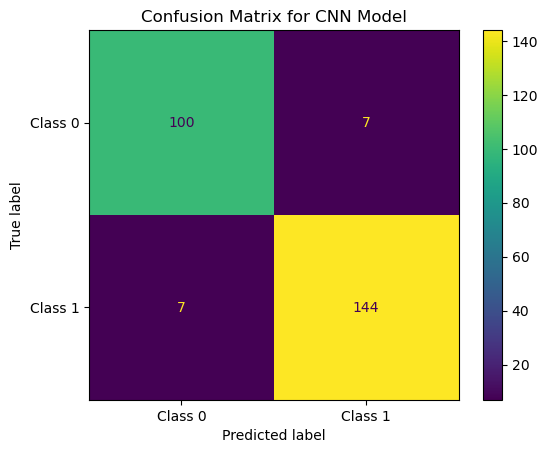

In [270]:
# Confusion Matrix
cm = confusion_matrix(val_y, val_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot()
plt.title('Confusion Matrix for CNN Model')
plt.show()

#### 5.3.2. Train and Validation Accuracy

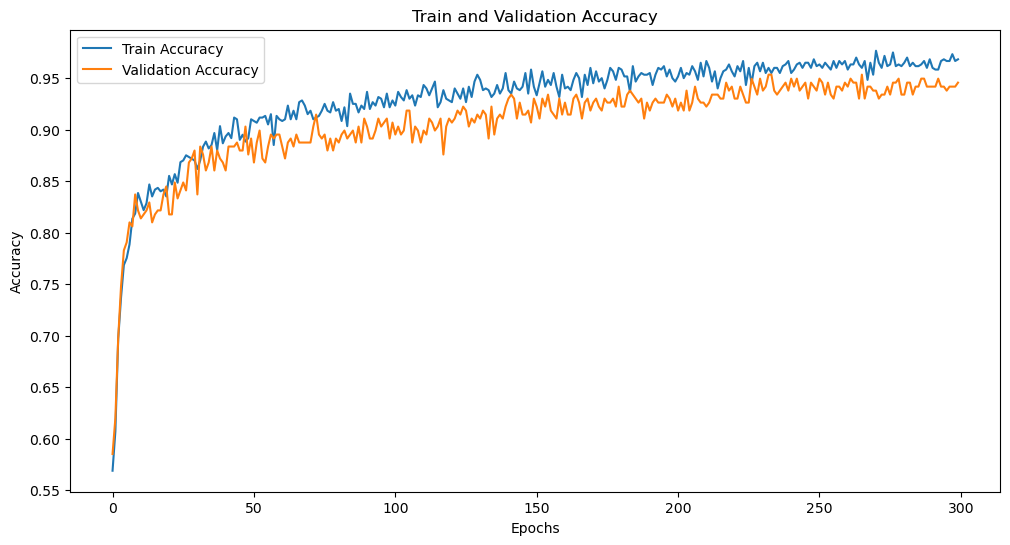

In [271]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

#### 5.3.3. Train and Validation Loss

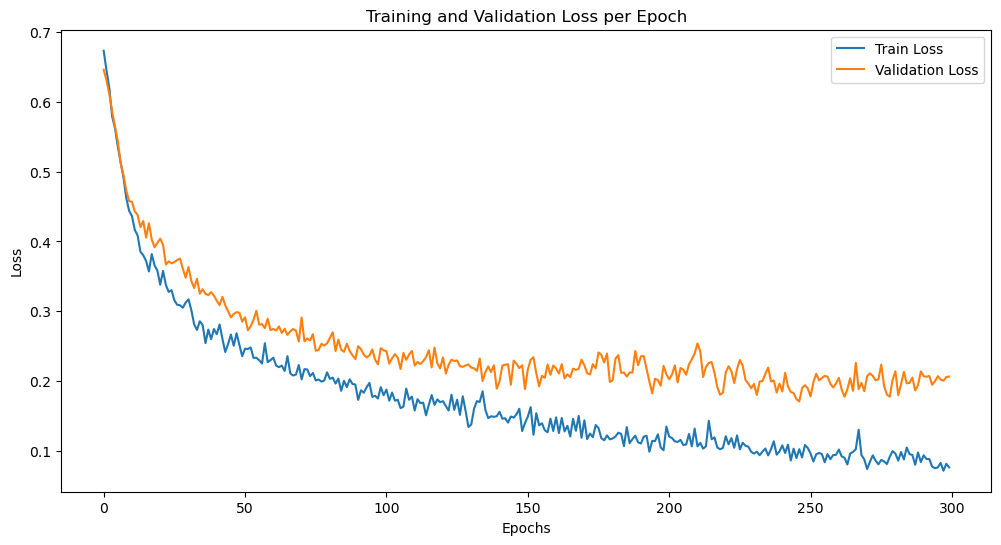

In [272]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

5.3.4 ROC

9/9 [==============================] - 0s 591us/step


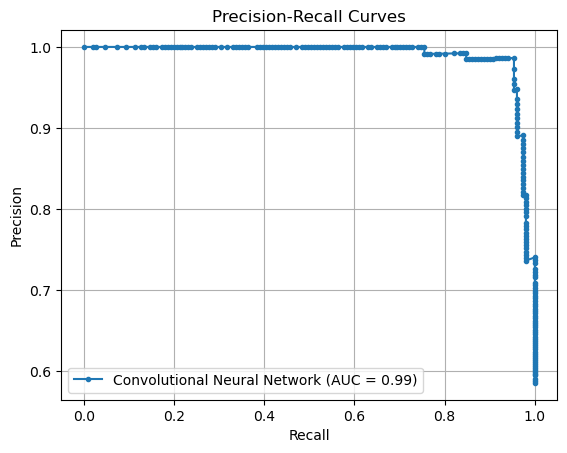

In [273]:
# Convolutional Neural Network
cnn_probs = model.predict(val_X).flatten()  # Get the probabilities for the positive class
plot_precision_recall_curve(val_y, cnn_probs, 'Convolutional Neural Network')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()